In [1]:
import os
import math
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
import random
import trimesh

import torch.nn.functional as F
from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj
from pytorch3d.ops import sample_points_from_meshes

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

from utils.plot_image_grid import image_grid

In [2]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [3]:
TRAINING_NUM_VIEWS = 32
IMAGE_SIZE = 224
TRIANGLE_GRID_RESOLUTION = 10
INITIAL_TRIANGLE_GRID_COUNT = TRIANGLE_GRID_RESOLUTION ** 3
RAND_SEED = 1337

In [4]:
def create_initial_triangle_grid(grid_resolution, device=None):
    if device is None:
        device = torch.device("cpu")

    vertex_list = []
    index_list = []

    cell_size = 2.0 / grid_resolution

    for x in range(grid_resolution):
        for y in range(grid_resolution):
            for z in range(grid_resolution):
                # 当前单元的最小坐标（归一化到[-1,1]）
                x_min = (x / grid_resolution) * 2 - 1
                y_min = (y / grid_resolution) * 2 - 1
                z_min = (z / grid_resolution) * 2 - 1
                
                # 在单元内生成三个随机点构成三角形
                v0 = [
                    x_min + random.random() * cell_size * 0.03,
                    y_min + random.random() * cell_size * 0.03,
                    z_min + random.random() * cell_size * 0.03
                ]
                v1 = [
                    x_min + random.random() * cell_size * 0.03,
                    y_min + random.random() * cell_size * 0.03,
                    z_min + random.random() * cell_size * 0.03
                ]
                v2 = [
                    x_min + random.random() * cell_size * 0.03,
                    y_min + random.random() * cell_size * 0.03,
                    z_min + random.random() * cell_size * 0.03
                ]
                
                # 添加顶点和面
                base_idx = len(vertex_list)
                vertex_list.extend([v0, v1, v2])
                index_list.append([base_idx, base_idx+1, base_idx+2])


    verts = torch.tensor(vertex_list, dtype=torch.float32, device=device)
    faces = torch.tensor(index_list, dtype=torch.int64, device=device)

    return Meshes(verts=[verts], faces=[faces])

In [5]:
def save_mesh_as_obj(mesh: Meshes, filename: str):
    """
    将PyTorch3D网格对象保存为OBJ文件
    
    参数：
    mesh: 要保存的Meshes对象（仅支持单批次网格）
    filename: 输出文件名（建议以.obj结尾）
    """
    # 检查输入是否为单批次网格
    assert len(mesh) == 1, "当前仅支持单网格导出"
    
    # 提取顶点和面数据
    verts = mesh.verts_packed().cpu()  # (V, 3)
    faces = mesh.faces_packed().cpu()  # (F, 3)
    
    # 转换数据类型
    verts = verts.to(torch.float32)
    faces = faces.to(torch.int64)

    
    # 保存OBJ文件
    save_obj(
        f=filename,
        verts=verts,
        faces=faces,
        verts_uvs=None,
        faces_uvs=None,
        texture_map=None
    )

In [6]:
# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "bunny_mesh/bunny.obj")

# Load obj file
input_mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = input_mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
input_mesh.offset_verts_(-center)
input_mesh.scale_verts_((1.0 / float(scale)));
save_mesh_as_obj(input_mesh, "output/mesh/input_mesh.obj")

occluder_mesh = create_initial_triangle_grid(TRIANGLE_GRID_RESOLUTION, device=device)


In [7]:
# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, TRAINING_NUM_VIEWS)
azim = torch.linspace(-180, 180, TRAINING_NUM_VIEWS)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], T=T[None, 1, ...]) 


In [8]:
# Rasterization settings for silhouette rendering  
sigma = 1e-5
raster_settings_silhouette = RasterizationSettings(
    image_size=IMAGE_SIZE, 
    blur_radius=np.log(1. / 1e-5 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
).to(device)

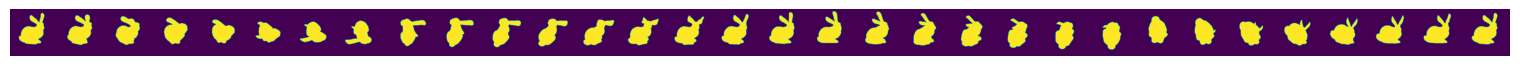

torch.Size([32, 1, 224, 224])


In [9]:
origin_meshes = input_mesh.extend(TRAINING_NUM_VIEWS)

# Render silhouette images.  The 3rd channel of the rendering output is the alpha/silhouette channel
origin_images = renderer_silhouette(origin_meshes, cameras=cameras, lights=lights)
origin_images[origin_images > 0] = 1.0

# Visualize silhouette images
image_grid(origin_images.cpu().numpy(), rows=(TRAINING_NUM_VIEWS - 1) // TRAINING_NUM_VIEWS + 1, cols=TRAINING_NUM_VIEWS, rgb=False)
plt.show()

gt_silhouettes = (origin_images[..., 3] > 0).float().unsqueeze(1)  # (B, 1, H, W)
print(gt_silhouettes.shape)

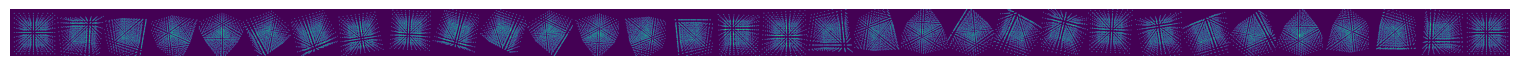

In [10]:
occluder_meshes = occluder_mesh.extend(TRAINING_NUM_VIEWS)

# Render silhouette images.  The 3rd channel of the rendering output is the alpha/silhouette channel
occluder_images = renderer_silhouette(occluder_meshes, cameras=cameras, lights=lights)
occluder_images[occluder_images > 0] = 1.0

target_silhouette = [occluder_images[i, ..., 3] for i in range(TRAINING_NUM_VIEWS)]

# Visualize silhouette images
image_grid(occluder_images.cpu().numpy(), rows=(TRAINING_NUM_VIEWS - 1) // TRAINING_NUM_VIEWS + 1, cols=TRAINING_NUM_VIEWS, rgb=False)
plt.show()

In [11]:
class TrLoss(nn.Module):
    def __init__(self, alpha=10, beta=1600, gamma=1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def calc_area_loss(self, verts):
        # 顶点形状: (num_triangles*3, 3)
        triangles = verts.view(-1, 3, 3)  # (N, 3, 3)
        v1 = triangles[:, 1] - triangles[:, 0]
        v2 = triangles[:, 2] - triangles[:, 0]
        cross = torch.cross(v1, v2, dim=1)
        area = 0.5 * torch.norm(cross, dim=1)
        return torch.log1p(area).mean()

    def forward(self, pred_silhouettes, gt_silhouettes, verts):
        # 过度遮挡损失
        # To prevent the output from over occlusion, we design an over occlusion loss $loss_o$
        loss_o = torch.mean((1 - gt_silhouettes) * pred_silhouettes) 

        # 形状匹配损失
        #  On the other hand, to encourage the network output to cover as many occluded pixels as possible, we define the occluded loss $loss_u$
        loss_u = -torch.mean(gt_silhouettes * pred_silhouettes)

        # 面积正则化
        #Finally, we need to penalize the network for using unnecessary triangles, we accomplish this by calculating the means of log area of all triangles
        loss_r = self.calc_area_loss(verts)
        
        return self.alpha * loss_u + self.beta * loss_o + self.gamma * loss_r

In [12]:
class ConvNeXtRegression(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        base_model = models.convnext_small(pretrained=True)  # 加载预训练权重
        
        # 调整第一层卷积为单通道输入
        original_conv = base_model.features[0][0]
        new_conv = nn.Conv2d(1, original_conv.out_channels, 
                            kernel_size=original_conv.kernel_size,
                            stride=original_conv.stride,
                            padding=original_conv.padding)
        
        # 初始化新卷积层权重：取RGB三通道均值
        with torch.no_grad():
            new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)
        
        base_model.features[0][0] = new_conv
        self.feature_extractor = base_model.features
        
        # 多视角特征聚合
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 回归头调整
        self.regressor = nn.Sequential(
            nn.Linear(768, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Linear(512, num_outputs)
        )

    def forward(self, x):
        # x形状: (num_views, 3, H, W)
        num_views = x.size(0)
        
        # 提取各视角特征
        features = [self.feature_extractor(x[i].unsqueeze(0)) for i in range(num_views)]
        features = torch.cat(features, dim=0)  # (num_views, 768, 7, 7)
        
        # 全局平均池化并聚合
        pooled = self.avgpool(features).view(num_views, -1)  # (num_views, 768)
        global_feature = pooled.mean(dim=0, keepdim=True)     # (1, 768)
        
        # 回归偏移量
        return self.regressor(global_feature)  # (1, num_outputs)

In [13]:
def create_offset_mesh(mesh, offset):
    vertex_list = mesh.verts_list()[0] + offset
    index_list = mesh.faces_list()[0]
    verts = torch.tensor(vertex_list, dtype=torch.float32, device=device)
    faces = torch.tensor(index_list, dtype=torch.int64, device=device)

    return Meshes(verts=[verts], faces=[faces])

In [14]:
# Number of optimization steps
Niter = 200

# The optimizer
model = ConvNeXtRegression(INITIAL_TRIANGLE_GRID_COUNT * 9).to(device)  # 每个三角形3顶点×3坐标
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = TrLoss(alpha=100, beta=2400, gamma=0.5)

/root/miniconda3/envs/real3dportrait/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/real3dportrait/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
loop = tqdm(range(Niter))

for i in loop:
    optimizer.zero_grad()

    elev = torch.rand(TRAINING_NUM_VIEWS) * 360
    azim = torch.rand(TRAINING_NUM_VIEWS) * 360 - 180
    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
    R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)

    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    
    with torch.no_grad():
        origin_images = renderer_silhouette(origin_meshes, cameras=cameras, lights=lights)
        gt_silhouettes = (origin_images[..., 3] > 0).float().unsqueeze(1)  # (B, 1, H, W)

    # 模型预测 
    offsets = model(gt_silhouettes)
    
    # 应用偏移量
    new_verts = occluder_mesh.verts_padded() + offsets.view(1, -1, 3)
    proxy_mesh = Meshes(verts=new_verts, faces=occluder_mesh.faces_padded())
    
    # 渲染代理
    pred_silhouettes = renderer_silhouette(proxy_mesh.extend(TRAINING_NUM_VIEWS), cameras=cameras)[..., 3].unsqueeze(1)  # (B, 1, H, W)

    # 计算损失
    loss = criterion(pred_silhouettes, gt_silhouettes, new_verts)
    
    # 反向传播
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {i}: Loss {loss.item():.4f}")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: Loss 1924.7144
Epoch 1: Loss 1910.5770
Epoch 2: Loss 1851.4791
Epoch 3: Loss 1770.0320
Epoch 4: Loss 1459.0260
Epoch 5: Loss 1299.9552
Epoch 6: Loss 1053.0676
Epoch 7: Loss 810.1553
Epoch 8: Loss 593.7885
Epoch 9: Loss 472.7037
Epoch 10: Loss 366.9592
Epoch 11: Loss 271.1800
Epoch 12: Loss 220.2457
Epoch 13: Loss 174.5027
Epoch 14: Loss 131.4743
Epoch 15: Loss 122.4860
Epoch 16: Loss 101.6530
Epoch 17: Loss 74.3877
Epoch 18: Loss 79.4682
Epoch 19: Loss 84.9937
Epoch 20: Loss 64.6368
Epoch 21: Loss 55.7964
Epoch 22: Loss 57.9795
Epoch 23: Loss 57.2844
Epoch 24: Loss 39.5846
Epoch 25: Loss 43.9134
Epoch 26: Loss 42.2590
Epoch 27: Loss 39.3932
Epoch 28: Loss 31.8230
Epoch 29: Loss 32.7442
Epoch 30: Loss 28.1809
Epoch 31: Loss 24.8938
Epoch 32: Loss 25.0306
Epoch 33: Loss 19.2459
Epoch 34: Loss 26.7548
Epoch 35: Loss 19.3209
Epoch 36: Loss 15.3045
Epoch 37: Loss 26.1033
Epoch 38: Loss 15.5246
Epoch 39: Loss 25.7019
Epoch 40: Loss 9.7732
Epoch 41: Loss 13.6749
Epoch 42: Loss 13.397

In [16]:
VOXEL_GRID_RES = 48 # 体素化分辨率
VOXEL_SIZE = 1 / VOXEL_GRID_RES


def visualize_point_cloud(points : torch.tensor, title = "Point Cloud"): # 可视化体素点云
    points = points.to("cpu").detach().numpy()
    fig = plt.figure(figsize=(10, 6))

    # 绘制点云
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(points[:,2], points[:,0], points[:,1], s=5, c=points[:,1], cmap='viridis')
    ax1.set_title(f"{title} (Point Count = {points.shape[0]})")
    ax1.set_axis_on()
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_zlim(-1, 1)
    plt.tight_layout()
    plt.show()

def safe_pytorch3d_to_trimesh(
    pytorch3d_mesh: Meshes, 
    index: int = 0,
    validate: bool = True
) -> trimesh.Trimesh: # 进行 pytorch3d 的 mesh 到 trimesh 的转换
    device = pytorch3d_mesh.device
    verts = pytorch3d_mesh.verts_padded()[index]
    faces = pytorch3d_mesh.faces_padded()[index]
    
    if device.type == 'cuda':
        verts = verts.detach().cpu()
        faces = faces.detach().cpu()
    
    verts_np = verts.numpy().astype(np.float64)
    faces_np = faces.numpy().astype(np.int32)
    
    tm_mesh = trimesh.Trimesh(
        vertices=verts_np, 
        faces=faces_np,
        process=validate
    )
    
    if validate:
        if not tm_mesh.is_watertight:
            print("Warning: The mesh is not watertight!")
        if tm_mesh.is_empty:
            raise ValueError("The result is an empty grid!")
            
    return tm_mesh

def voxelization(pytorch3d_mesh: Meshes) -> torch.tensor:
    new_mesh = safe_pytorch3d_to_trimesh(pytorch3d_mesh)
    voxel_grid = new_mesh.voxelized(pitch=VOXEL_SIZE) # 生成体素网格
    voxel_centers = voxel_grid.points
    voxel_centers = torch.as_tensor(
        np.ascontiguousarray(voxel_centers, dtype=np.float32),
        device=device
    )
    voxel_centers += torch.rand_like(voxel_centers) * VOXEL_SIZE
    return voxel_centers

def sample_mesh_to_point_cloud(
    mesh: Meshes,
    num_edge_samples_per_edge: int = 32,
    num_face_samples_per_face: int = 512
) -> torch.Tensor:
    """
    从网格的顶点、边和面生成点云。
    
    参数:
        mesh: PyTorch3D的Meshes对象，仅支持单个mesh。
        num_edge_samples_per_edge: 每条边的采样点数（不包括端点）。
        num_face_samples: 面采样的总点数。
    
    返回:
        point_cloud: 合并后的点云，形状为[N, 3]。
    """
    assert len(mesh) == 1, "函数仅支持单个mesh"
    
    # 提取顶点和面
    verts = mesh.verts_packed()  # [V, 3]
    faces = mesh.faces_packed()  # [F, 3]
    
    # 顶点采样
    vertex_points = verts
    
    # 边采样
    edges_set = set()
    for face in faces:
        face = face.tolist()
        edges = [
            tuple(sorted([face[0], face[1]])),
            tuple(sorted([face[1], face[2]])),
            tuple(sorted([face[2], face[0]]))
        ]
        edges_set.update(edges)
    edges = list(edges_set)
    
    edge_points = []
    if num_edge_samples_per_edge > 0:
        ts = torch.linspace(0.0, 1.0, num_edge_samples_per_edge + 2, device=verts.device)[1:-1]
        for (v0_idx, v1_idx) in edges:
            v0 = verts[v0_idx]
            v1 = verts[v1_idx]
            points = v0.unsqueeze(0) * (1 - ts).unsqueeze(1) + v1.unsqueeze(0) * ts.unsqueeze(1)
            edge_points.append(points)
        edge_points = torch.cat(edge_points, dim=0) if edge_points else torch.zeros((0, 3), device=verts.device)
    else:
        edge_points = torch.zeros((0, 3), device=verts.device)
    
    # 面采样
    if num_face_samples_per_face > 0:
        face_points = sample_points_from_meshes(mesh, num_samples=num_face_samples_per_face * faces.shape[0])[0]
    else:
        face_points = torch.zeros((0, 3), device=verts.device)
    
    # 合并点云
    point_cloud = torch.cat([vertex_points, edge_points, face_points], dim=0)
    
    return point_cloud

In [17]:
def delete_small_triangles(mesh, threshold):
    """
    直接删除网格中面积小于阈值的三角形，返回新网格
    
    Args:
        mesh (Meshes): PyTorch3D的Meshes对象（仅单个网格）
        threshold (float): 面积阈值
    
    Returns:
        Meshes: 处理后的新网格，包含所有面积≥阈值的三角形
    """
    assert mesh._N == 1, "仅支持单个网格处理"
    
    # 获取顶点和面数据
    verts = mesh.verts_packed()  # [V, 3]
    faces = mesh.faces_packed()  # [F, 3]
    
    # ------ 步骤1: 计算每个三角形面积 ------
    # 提取三角形顶点坐标 [F, 3, 3]
    tri_verts = verts[faces]
    v0, v1, v2 = tri_verts[:, 0], tri_verts[:, 1], tri_verts[:, 2]
    # 计算叉乘面积
    cross = torch.cross(v1 - v0, v2 - v0, dim=1)
    area = torch.norm(cross, dim=1) / 2.0  # [F]
    
    # ------ 步骤2: 生成删除掩码 ------
    delete_mask = area < threshold  # True表示要删除的面
    
    # ------ 步骤3: 保留有效面 ------
    valid_faces = faces[~delete_mask]  # 保留面积≥阈值的面
    
    # ------ 步骤4: 重建网格（删除未引用的顶点） ------
    # 获取被保留下来的顶点索引
    used_verts_idx = torch.unique(valid_faces.flatten())
    # 构建顶点映射表
    verts_map = torch.full((verts.shape[0],), -1, dtype=torch.long, device=verts.device)
    verts_map[used_verts_idx] = torch.arange(len(used_verts_idx), device=verts.device)
    # 更新面的顶点索引
    new_faces = verts_map[valid_faces]
    new_verts = verts[used_verts_idx]
    
    # 返回新网格
    return Meshes(verts=[new_verts], faces=[new_faces])

[Preliminary Occluder] triangle count =  1000


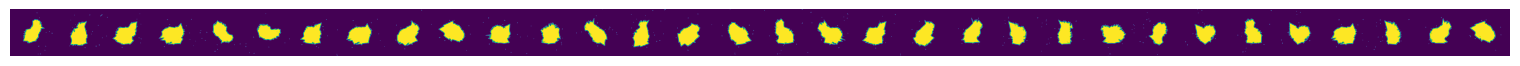

In [18]:
offsets = model(gt_silhouettes)
new_verts = occluder_mesh.verts_padded() + offsets.view(1, -1, 3)
proxy_mesh = Meshes(verts=new_verts, faces=occluder_mesh.faces_padded())
print("[Preliminary Occluder] triangle count = ", proxy_mesh.verts_list()[0].shape[0] // 3)

# elev = torch.linspace(0, 360, TRAINING_NUM_VIEWS)
# azim = torch.linspace(-180, 180, TRAINING_NUM_VIEWS)
# lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
# R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)

pred_silhouettes = renderer_silhouette(proxy_mesh.extend(TRAINING_NUM_VIEWS), cameras=FoVPerspectiveCameras(device=device, R=R, T=T))
pred_silhouettes = pred_silhouettes.detach()
image_grid(pred_silhouettes.cpu().numpy(), rows=(TRAINING_NUM_VIEWS - 1) // TRAINING_NUM_VIEWS + 1, cols=TRAINING_NUM_VIEWS, rgb=False)
plt.show()
save_mesh_as_obj(proxy_mesh, "output/mesh/preliminary_occluder_mesh.obj")

[Preliminary Occluder] after delete small triangle, triangle count =  45


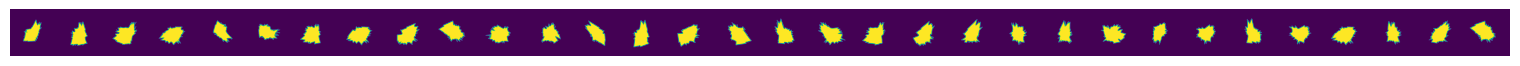

In [19]:
proxy_mesh = delete_small_triangles(proxy_mesh, 0.2)
print("[Preliminary Occluder] after delete small triangle, triangle count = ", proxy_mesh.verts_list()[0].shape[0] // 3)

pred_silhouettes = renderer_silhouette(proxy_mesh.extend(TRAINING_NUM_VIEWS), cameras=FoVPerspectiveCameras(device=device, R=R, T=T))
pred_silhouettes = pred_silhouettes.detach()
image_grid(pred_silhouettes.cpu().numpy(), rows=(TRAINING_NUM_VIEWS - 1) // TRAINING_NUM_VIEWS + 1, cols=TRAINING_NUM_VIEWS, rgb=False)
plt.show()
save_mesh_as_obj(proxy_mesh, "output/mesh/preliminary_occluder_mesh_2.obj")

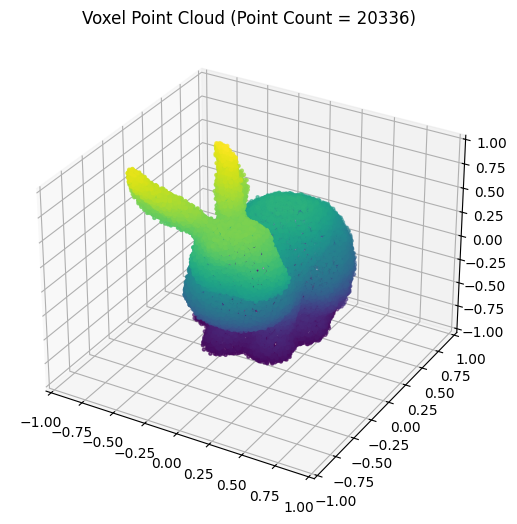

In [20]:
voxel_point_cloud = voxelization(input_mesh)
visualize_point_cloud(voxel_point_cloud, "Voxel Point Cloud")

torch.Size([27495, 3])


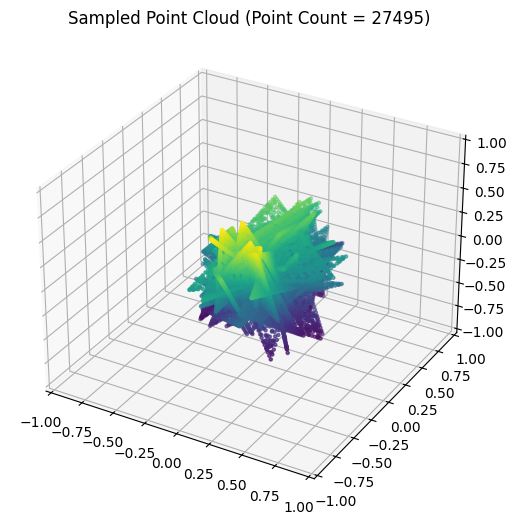

In [21]:
occluder_point_cloud = sample_mesh_to_point_cloud(proxy_mesh)
print(occluder_point_cloud.shape)
visualize_point_cloud(occluder_point_cloud, "Sampled Point Cloud")

In [23]:
class OpLoss(TrLoss):
    def __init__(self, alpha=10, beta=1600, gamma=1, delta=20):
        super().__init__(alpha, beta, gamma)
        self.delta = delta
        self.mu = math.sqrt(3 / 4) * VOXEL_SIZE

    def calc_structure_loss(self, voxel_point_cloud, occluder_point_cloud):
        """
        计算点云预测的损失函数。
        
        Args:
            voxel_point_cloud (torch.Tensor): 原始物体体素化后得到的点云，形状为 [B, N, 3]
            occluder_point_cloud (torch.Tensor): 遮挡代理体的点云，形状为 [B, M, 3]
            mu (float): 距离阈值超参数
        
        Returns:
            torch.Tensor: 计算得到的损失值
        """
        # 计算所有点对之间的欧氏距离矩阵，形状为 [B, N, M]
        dist_matrix = torch.cdist(voxel_point_cloud, occluder_point_cloud, p=2)
        
        # 对每个预测点PO_j找到最近的输入点PI_i的距离，形状为 [B, M]
        min_dists, _ = torch.min(dist_matrix, dim=1)
        
        # 计算 max(最小距离 - mu, 0) 并求平均
        loss_s = torch.mean(torch.clamp(min_dists - self.mu, min=0))
        
        return loss_s

    def forward(self, pred_silhouettes, gt_silhouettes, verts, voxel_point_cloud, occluder_point_cloud):
        return super().forward(pred_silhouettes, gt_silhouettes, verts) + self.delta * self.calc_structure_loss(voxel_point_cloud, occluder_point_cloud)

True


  0%|          | 0/1000 [00:00<?, ?it/s]

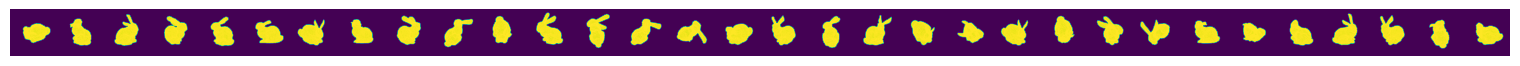

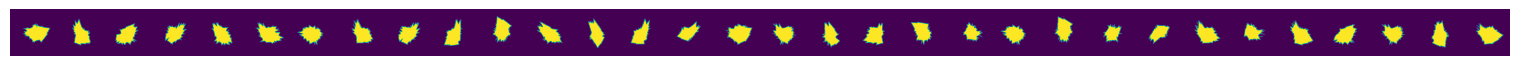

Epoch 0: Loss -6.3226


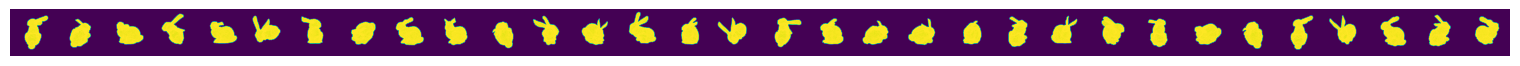

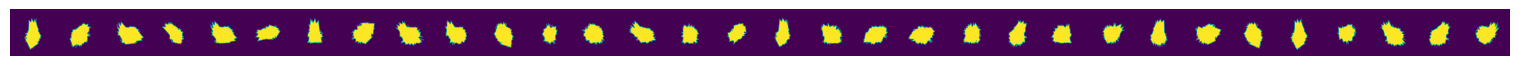

Epoch 25: Loss -9.7559


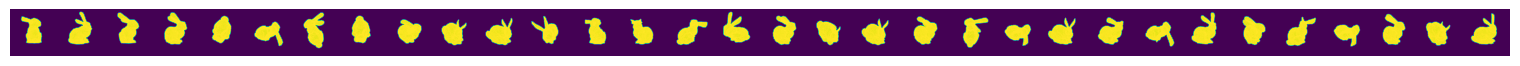

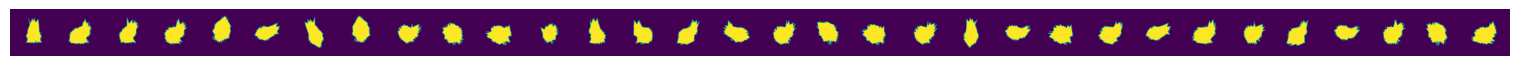

Epoch 50: Loss -10.7190


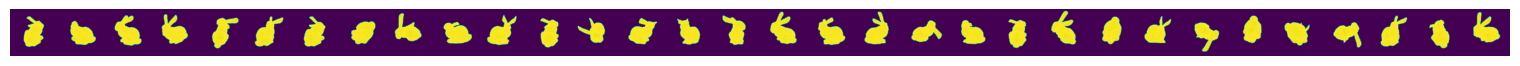

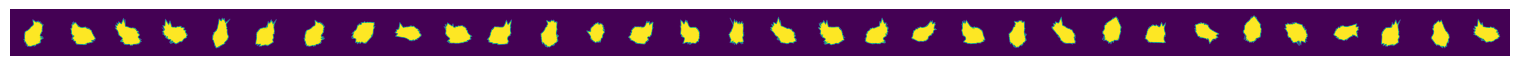

Epoch 75: Loss -11.7077


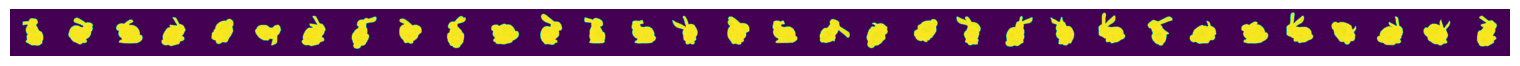

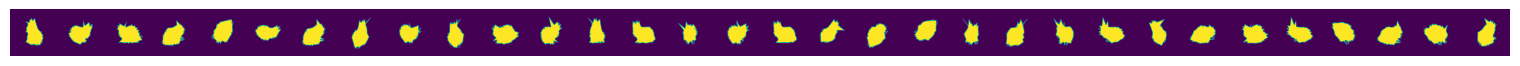

Epoch 100: Loss -11.8316


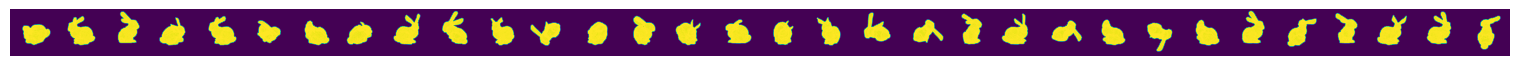

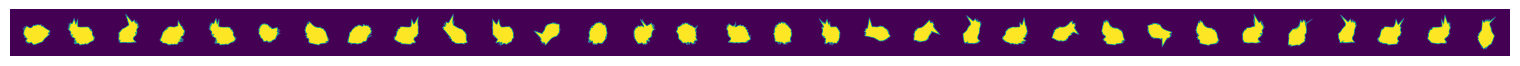

Epoch 125: Loss -12.3139


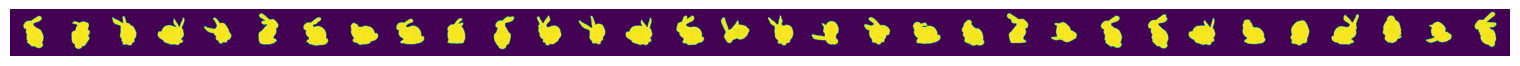

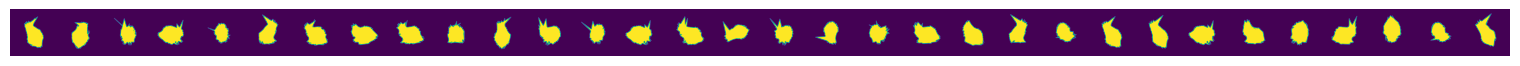

Epoch 150: Loss -12.0874


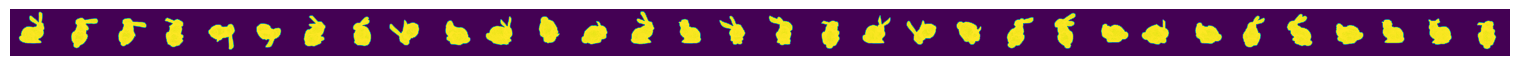

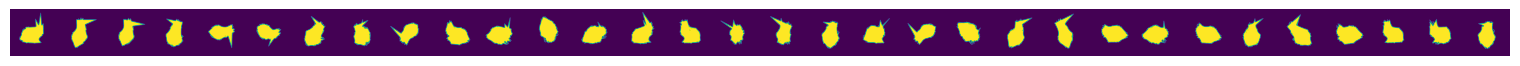

Epoch 175: Loss -12.5728


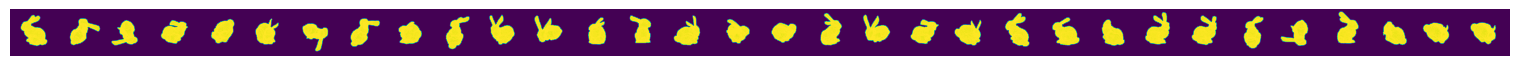

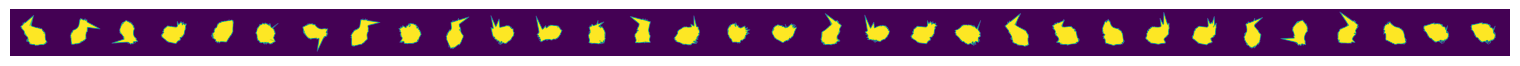

Epoch 200: Loss -12.6015


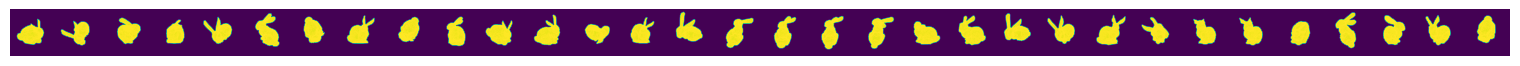

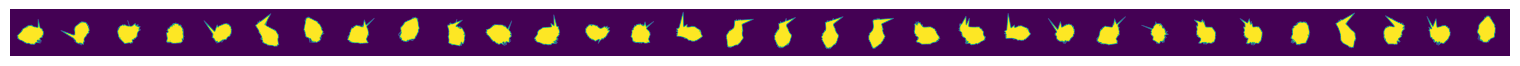

Epoch 225: Loss -12.5285


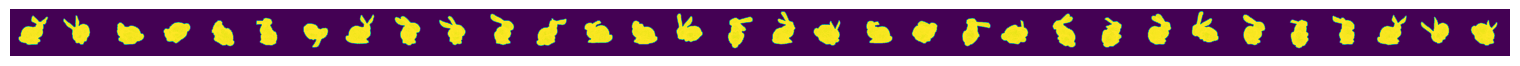

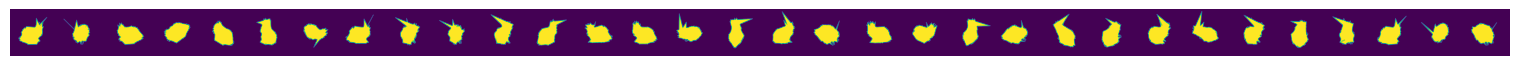

Epoch 250: Loss -12.8087


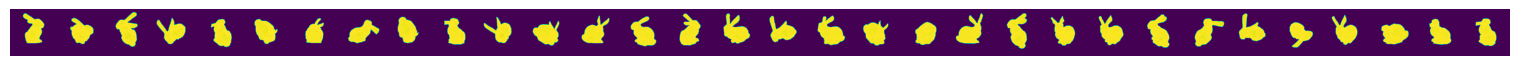

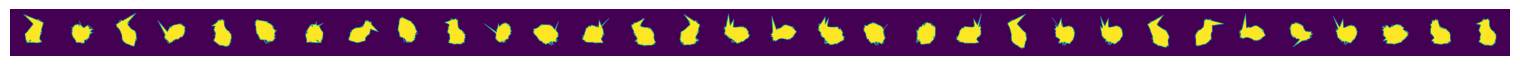

Epoch 275: Loss -12.6713


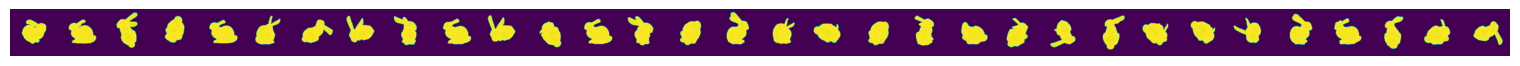

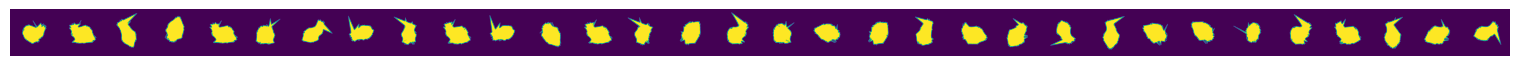

Epoch 300: Loss -12.9942


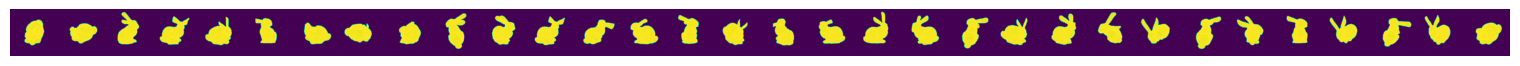

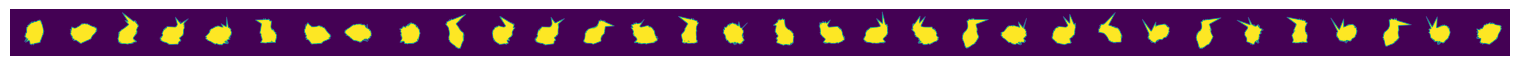

Epoch 325: Loss -13.3311


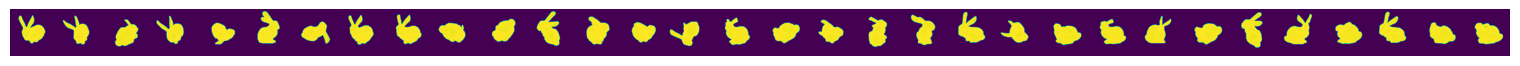

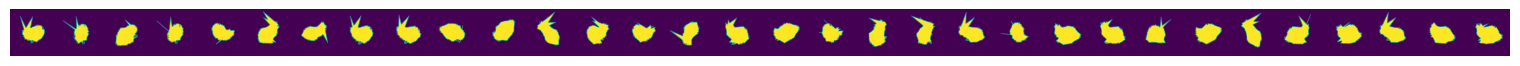

Epoch 350: Loss -13.2505


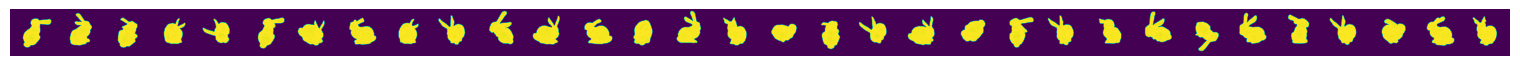

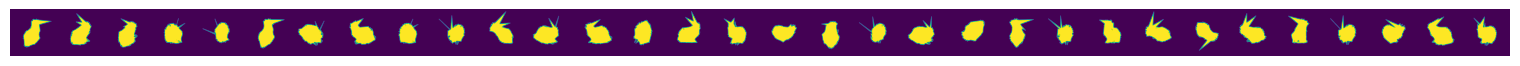

Epoch 375: Loss -12.9660


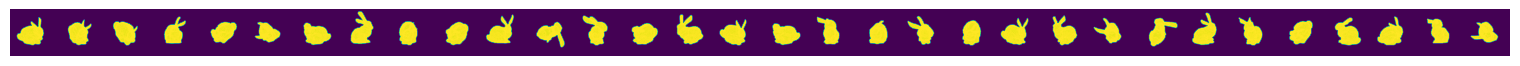

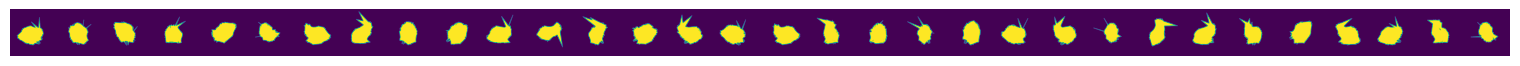

Epoch 400: Loss -13.2066


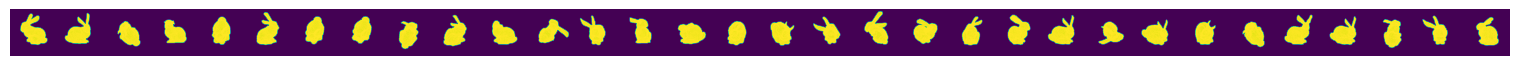

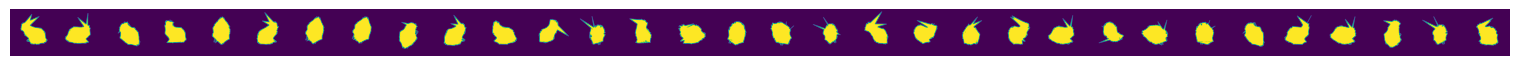

Epoch 425: Loss -13.5270


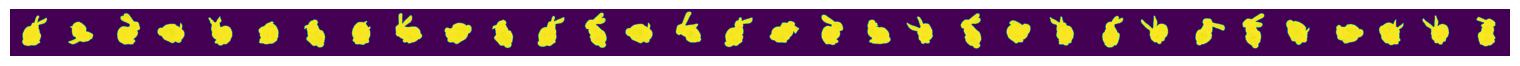

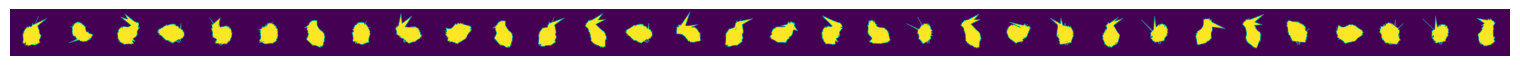

Epoch 450: Loss -13.1600


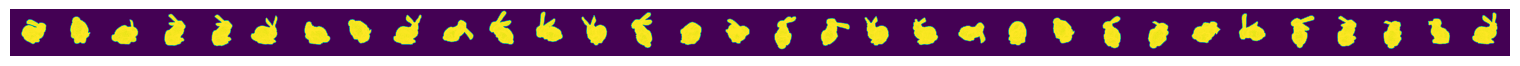

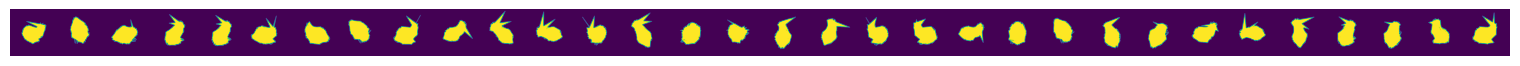

Epoch 475: Loss -13.6643


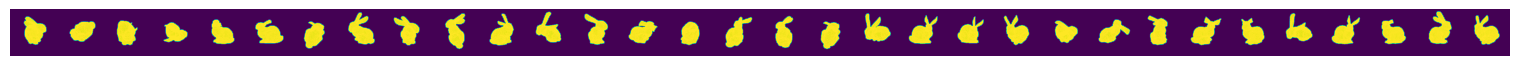

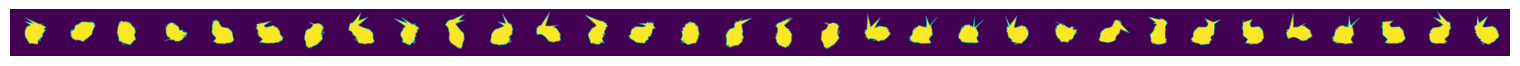

Epoch 500: Loss -13.5655


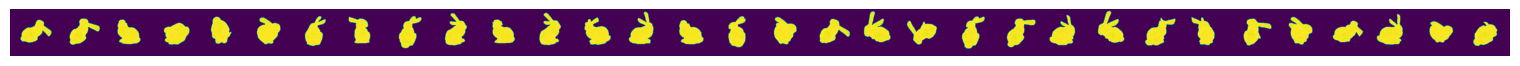

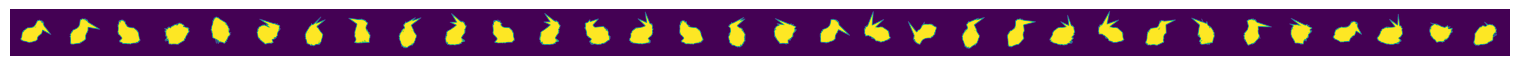

Epoch 525: Loss -13.5508


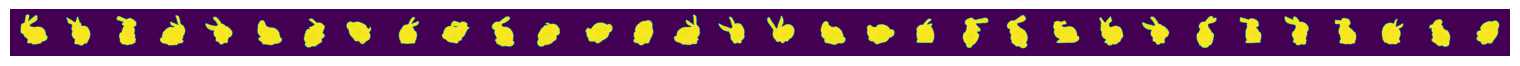

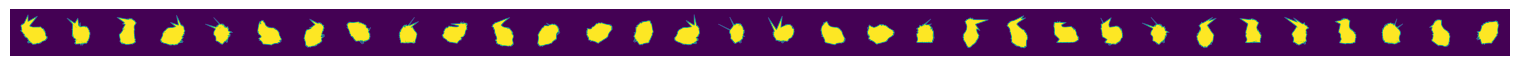

Epoch 550: Loss -13.0515


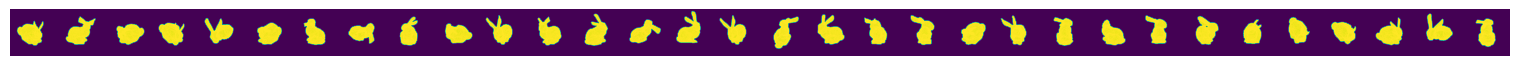

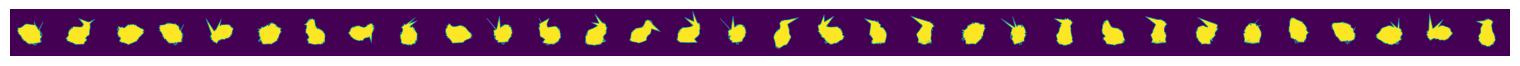

Epoch 575: Loss -13.4006


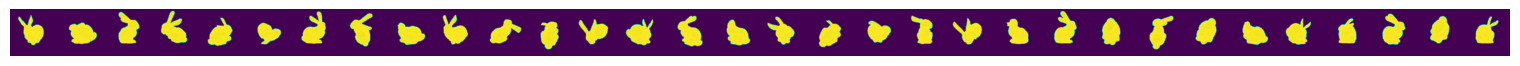

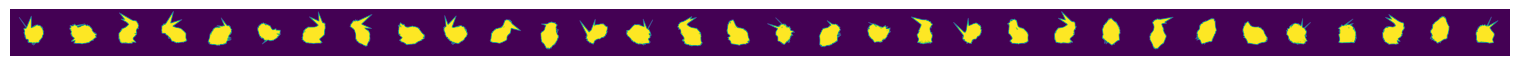

Epoch 600: Loss -13.4958


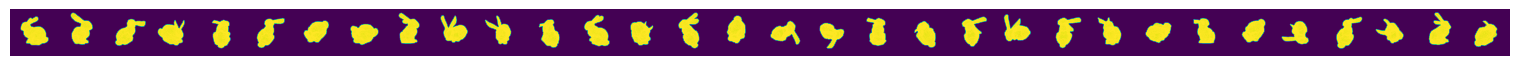

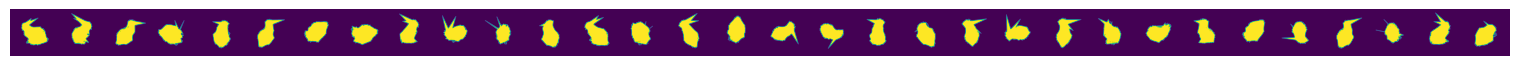

Epoch 625: Loss -13.2928


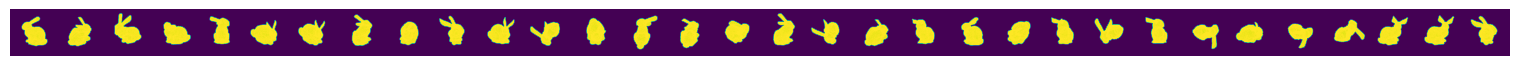

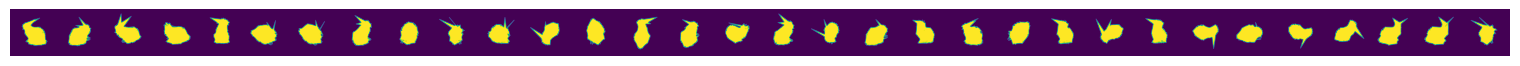

Epoch 650: Loss -13.3876


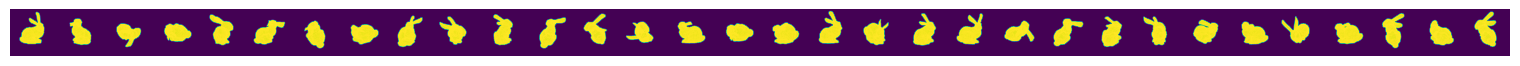

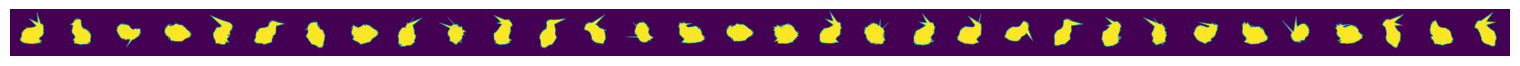

Epoch 675: Loss -13.6141


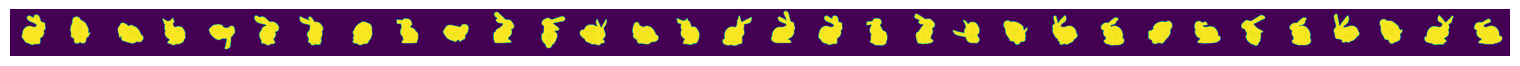

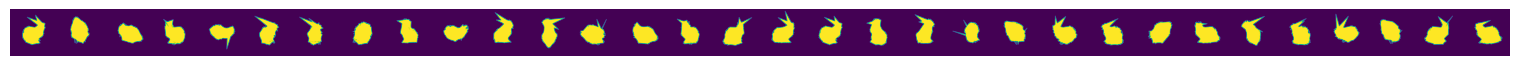

Epoch 700: Loss -13.7551


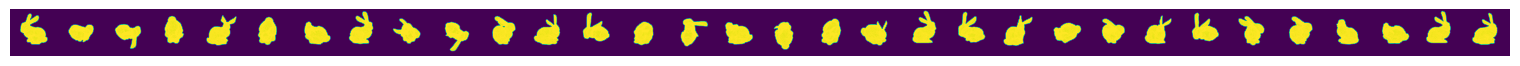

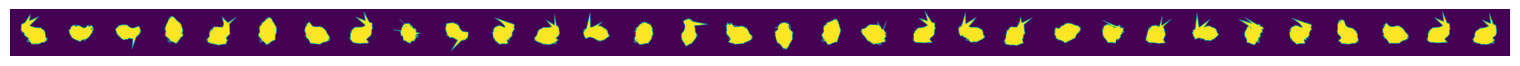

Epoch 725: Loss -13.9328


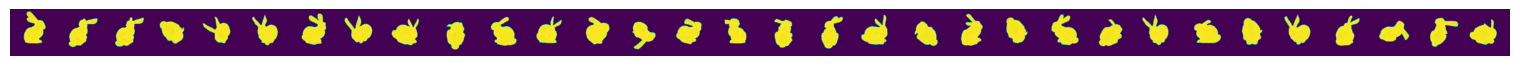

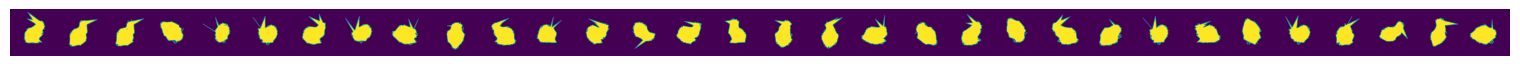

Epoch 750: Loss -13.5902


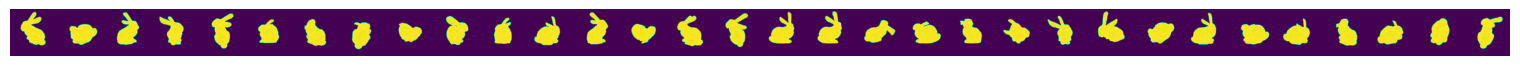

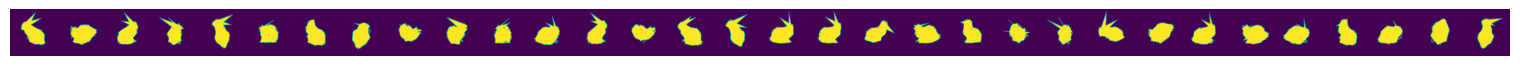

Epoch 775: Loss -13.7002


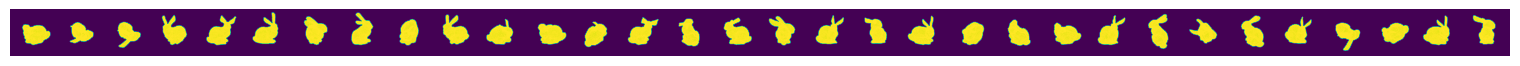

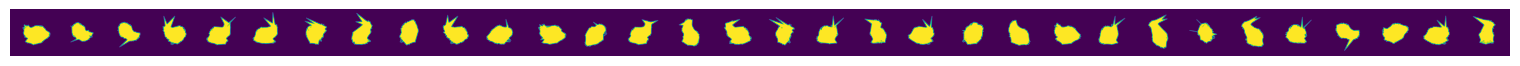

Epoch 800: Loss -13.8896


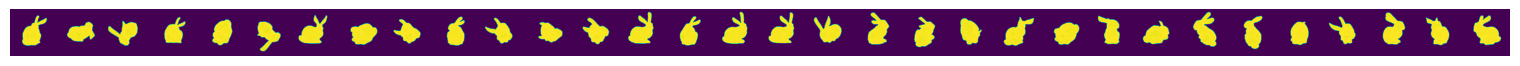

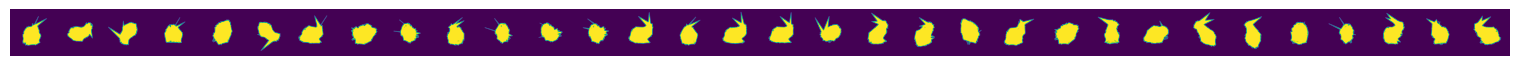

Epoch 825: Loss -13.0061


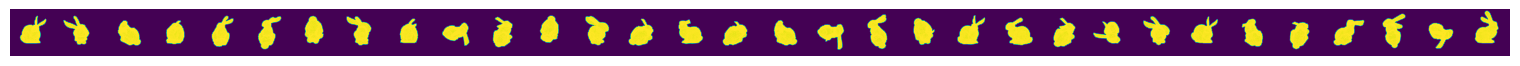

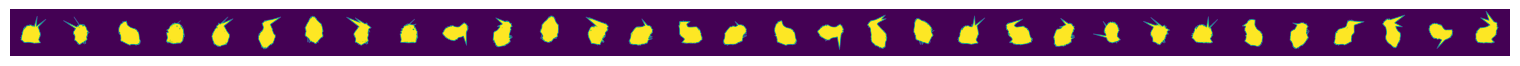

Epoch 850: Loss -13.1391


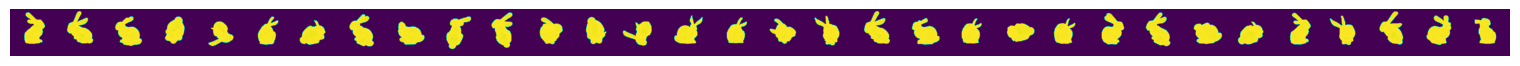

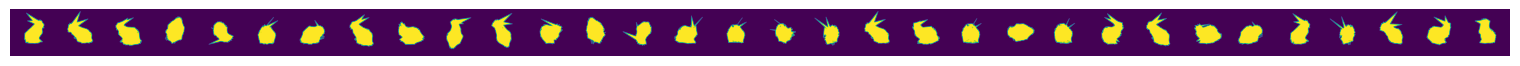

Epoch 875: Loss -13.5896


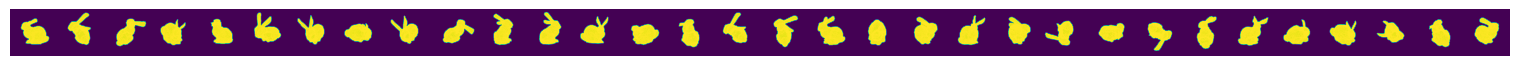

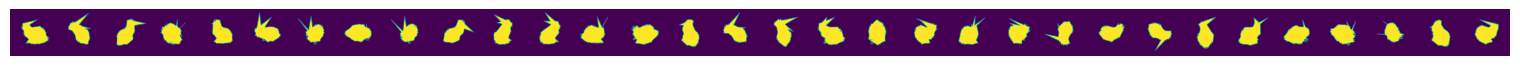

Epoch 900: Loss -13.4669


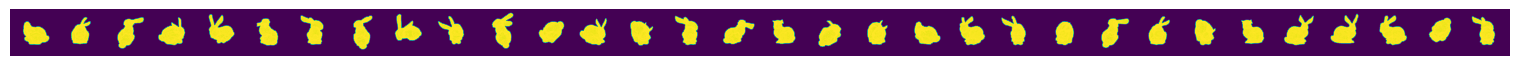

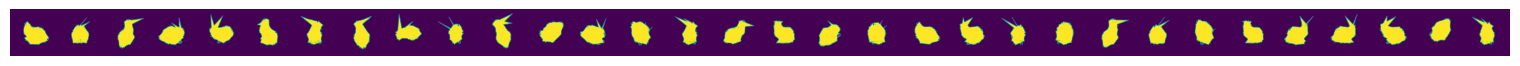

Epoch 925: Loss -13.4401


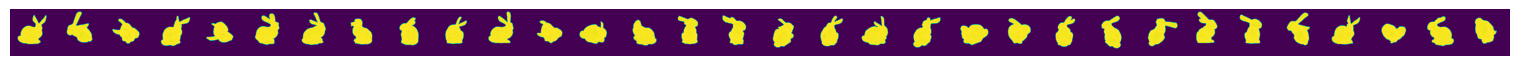

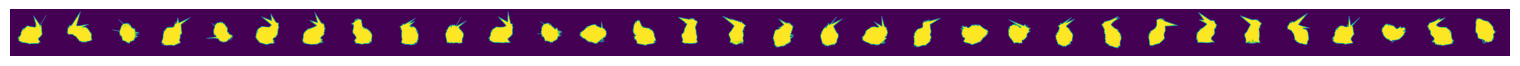

Epoch 950: Loss -13.2725


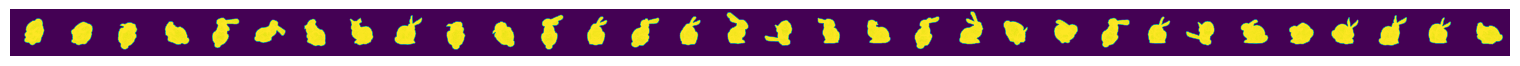

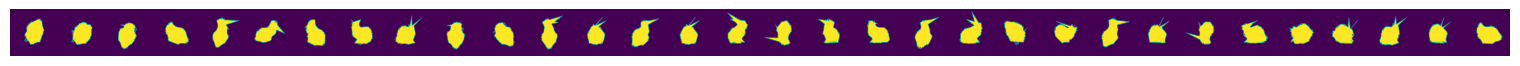

Epoch 975: Loss -13.3372


In [24]:
Niter = 1000
new_verts = proxy_mesh.verts_list()[0].detach()
new_verts.requires_grad_()
print(new_verts.requires_grad)
optimizer = torch.optim.Adam([new_verts], lr=0.005)
loop = tqdm(range(Niter))
op_loss = OpLoss(alpha = 100, beta=2400, gamma=0.5, delta=30)

# 使用可微渲染进行进一步优化，生成 Final Occluder
for i in loop:
    optimizer.zero_grad()

    elev = torch.rand(TRAINING_NUM_VIEWS) * 360
    azim = torch.rand(TRAINING_NUM_VIEWS) * 360 - 180
    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
    R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)

    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    with torch.no_grad():
        origin_images = renderer_silhouette(origin_meshes, cameras=cameras, lights=lights)
        gt_silhouettes = (origin_images[..., 3] > 0).float().unsqueeze(1)  # (B, 1, H, W)

    current_proxy_mesh = Meshes(verts=[new_verts], faces=[proxy_mesh.faces_list()[0]])
    occluder_point_cloud = sample_mesh_to_point_cloud(current_proxy_mesh)
    
    pred_silhouettes = renderer_silhouette(current_proxy_mesh.extend(TRAINING_NUM_VIEWS), cameras=cameras)[..., 3].unsqueeze(1)  # (B, 1, H, W)

    loss = op_loss(pred_silhouettes, gt_silhouettes, new_verts, voxel_point_cloud, occluder_point_cloud)
    
    loss.backward()
    optimizer.step()
    
    if i % 25 == 0:
        with torch.no_grad():
            preview_gt_silhouettes = renderer_silhouette(origin_meshes, cameras=cameras, lights=lights)
            preview_pred_silhouettes = renderer_silhouette(current_proxy_mesh.extend(TRAINING_NUM_VIEWS), cameras=cameras)

        image_grid(preview_gt_silhouettes.cpu().numpy(), rows=(TRAINING_NUM_VIEWS - 1) // TRAINING_NUM_VIEWS + 1, cols=TRAINING_NUM_VIEWS, rgb=False)
        plt.show()
        image_grid(preview_pred_silhouettes.cpu().numpy(), rows=(TRAINING_NUM_VIEWS - 1) // TRAINING_NUM_VIEWS + 1, cols=TRAINING_NUM_VIEWS, rgb=False)
        plt.show()
    
        print(f"Epoch {i}: Loss {loss.item():.4f}")

[Final Occluder] before delete small triangle, triangle count =  47


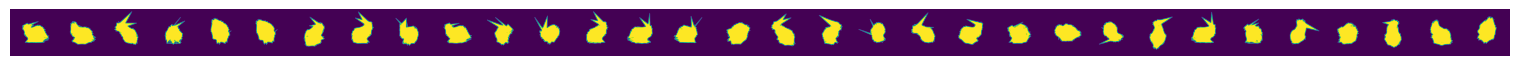

In [ ]:
final_occluder_mesh = current_proxy_mesh
print("[Final Occluder] before delete small triangle, triangle count = ", final_occluder_mesh.verts_list()[0].shape[0] // 3)

pred_silhouettes = renderer_silhouette(final_occluder_mesh.extend(TRAINING_NUM_VIEWS), cameras=FoVPerspectiveCameras(device=device, R=R, T=T))
pred_silhouettes = pred_silhouettes.detach()
image_grid(pred_silhouettes.cpu().numpy(), rows=(TRAINING_NUM_VIEWS - 1) // TRAINING_NUM_VIEWS + 1, cols=TRAINING_NUM_VIEWS, rgb=False)
plt.show()

[Final Occluder] after delete small triangle, triangle count =  47


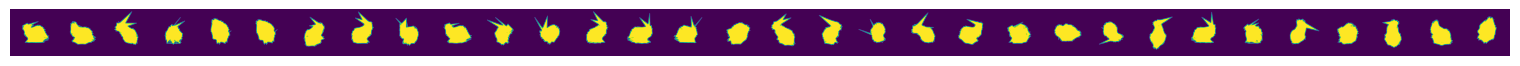

In [26]:
final_occluder_mesh_2 = delete_small_triangles(final_occluder_mesh, 0.00001)
print("[Final Occluder] after delete small triangle, triangle count = ", final_occluder_mesh_2.verts_list()[0].shape[0] // 3)

pred_silhouettes = renderer_silhouette(final_occluder_mesh_2.extend(TRAINING_NUM_VIEWS), cameras=FoVPerspectiveCameras(device=device, R=R, T=T))
pred_silhouettes = pred_silhouettes.detach()
image_grid(pred_silhouettes.cpu().numpy(), rows=(TRAINING_NUM_VIEWS - 1) // TRAINING_NUM_VIEWS + 1, cols=TRAINING_NUM_VIEWS, rgb=False)
plt.show()

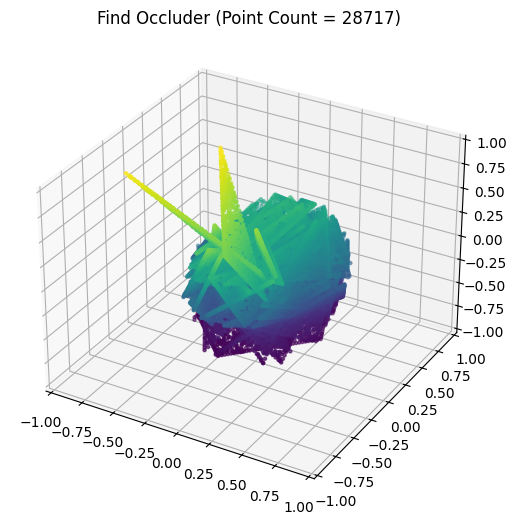

In [ ]:
final_occluder_point_cloud = sample_mesh_to_point_cloud(final_occluder_mesh)
visualize_point_cloud(final_occluder_point_cloud, "Find Occluder")

In [ ]:
save_mesh_as_obj(final_occluder_mesh, "output/mesh/final_occluder_mesh.obj")